In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import random
from IPython.display import display, HTML
from collections import defaultdict
from bs4 import BeautifulSoup

## Definition and creation of teams and groups:

In [2]:
class Team:
    def __init__(self, name, group) -> None:
        self.name = name
        self.group = group
        self.gf = 0  # goals for
        self.ga = 0  # goals against
        self.results = defaultdict(lambda: [0, 0])  # matches results in format [this team's goals, other team's goals]
        self.yellows = 0  # yellow cards
        self.reds = 0  # red cards
        self.yellow_yellows = 0  # second yellow cards
        self.yellow_reds = 0  # red after yellow cards

    def points(self):  # calculates current number of points, 3 for a win, 1 for a draw, 0 for a loss
        pts = 0
        for team in self.results:
            score = self.results[team]
            if score[0] > score[1]:
                pts += 3
            elif score[0] == score[1]:
                pts += 1
        return pts

    def conduct_score(self):
        return -(self.yellows-self.yellow_yellows-self.yellow_reds) - 2*self.yellow_yellows - 4*self.reds - 5*self.yellow_reds

In [3]:
class Group:
    def __init__(self, name, teams, teams_map) -> None:
        self.name = name
        self.teams = teams
        self.teams_map = teams_map
        self.after_two_weeks_ranking = None
        self.ranking_changes = []
        self.final_ranking = None

    def tiebreaker(self, teams):  # resolves tie by calculating points, gf, and ga, between the teams concerned
        tie_map = {team: {'points': 0, 'gf': 0, 'ga': 0} for team in teams}
        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                goals_i, goals_j = self.teams_map[teams[i]].results[teams[j]]
                tie_map[teams[i]]['gf'] += goals_i
                tie_map[teams[i]]['ga'] += goals_j
                tie_map[teams[j]]['gf'] += goals_j
                tie_map[teams[j]]['ga'] += goals_i
                if goals_i > goals_j:
                    tie_map[teams[i]]['points'] += 3
                elif goals_j > goals_i:
                    tie_map[teams[j]]['points'] += 3
                else:
                    tie_map[teams[i]]['points'] += 1
                    tie_map[teams[j]]['points'] += 1
        return sorted(teams, key=lambda x: (tie_map[x]['points'], tie_map[x]['gf']-tie_map[x]['ga'], tie_map[x]['gf'], self.teams_map[x].conduct_score(), random.randint(1, 1000)), reverse=True)
    
    def rank(self, team):  # used to compare teams between them 
        return (self.teams_map[team].points(), self.teams_map[team].gf-self.teams_map[team].ga, self.teams_map[team].gf)

    def sort_teams(self): # starts by comparing teams by points, then by goals difference, then goals scored, then tiebreaker rules
        self.teams.sort(key=lambda x: self.rank(x), reverse=True)
        if len(set([self.rank(x) for x in self.teams])) == 1:  # tie between the four teams
            pass
        elif len(set([self.rank(x) for x in self.teams[:3]])) == 1:  # tie between the 1st, 2nd, and 3rd
            self.teams = self.tiebreaker(self.teams[:3]) + [self.teams[3]]
        elif len(set([self.rank(x) for x in self.teams[1:]])) == 1:  # tie between the 2nd, 3rd, and 4th
            self.teams = [self.teams[0]] + self.tiebreaker(self.teams[1:])
        elif self.rank(self.teams[1]) == self.rank(self.teams[2]):  # tie between the 2nd and 3rd
            self.teams = [self.teams[0]] + self.tiebreaker([self.teams[1], self.teams[2]]) + [self.teams[3]]
        if self.rank(self.teams[0]) == self.rank(self.teams[1]):  # tie between the 1st and 2nd
            self.teams = self.tiebreaker([self.teams[0], self.teams[1]]) + self.teams[2:]
        if self.rank(self.teams[2]) == self.rank(self.teams[3]):  # tie between the 3rd and 4th
            self.teams = self.teams[:2] + self.tiebreaker([self.teams[2], self.teams[3]])

In [4]:
teams_map = {}  # maps team name to Team object
groups_map = {  # maps group name to Group object
    'A': Group('A', ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'], teams_map),
    'B': Group('B', ['England', 'IR Iran', 'United States', 'Wales'], teams_map),
    'C': Group('C', ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'], teams_map),
    'D': Group('D', ['France', 'Australia', 'Denmark', 'Tunisia'], teams_map),
    'E': Group('E', ['Spain', 'Costa Rica', 'Germany', 'Japan'], teams_map),
    'F': Group('F', ['Belgium', 'Canada', 'Morocco', 'Croatia'], teams_map),
    'G': Group('G', ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'], teams_map),
    'H': Group('H', ['Portugal', 'Ghana', 'Uruguay', 'Korea Republic'], teams_map)
}
for group in groups_map:
    for team in groups_map[group].teams:
        teams_map[team] = Team(team, group)

## Data extraction:

The website https://fbref.com has been used to extract data about the different matches of the knockout stage

In [5]:
fixtures_data_url = 'https://fbref.com/en/comps/1/schedule/World-Cup-Scores-and-Fixtures'
data = requests.get(fixtures_data_url)
soup = BeautifulSoup(data.text)

In [6]:
table = soup.find_all('table')[1]
body = table.find('tbody')
rows = body.find_all('tr')
matches = []
report_urls = []
for row in rows:  # for each match we extract (group, gameweek, team 1, team 2, goals scored by team 1, goals scored by team 2, report link)
    gameweek = row.find('th', {'data-stat': 'gameweek'}).text
    score = row.find('td', {'data-stat': 'score'}).text
    if gameweek and score:
        team_1 = row.find('td', {'data-stat': 'home_team'}).find('a').text
        team_2 = row.find('td', {'data-stat': 'away_team'}).find('a').text
        group = teams_map[team_1].group
        goals_1, goals_2 = score.split('–')
        report_url = row.find('td', {'data-stat': 'match_report'}).find('a').get('href')
        matches.append([group, int(gameweek), team_1, team_2, int(goals_1), int(goals_2), f'https://fbref.com{report_url}'])
    

In [7]:
events = []
# for each match, the match report is opened then we extract events that might impact group ranking (goals and cards)
for group, gameweek, team_1, team_2, goals_1, goals_2, report_url in matches:
    data = requests.get(report_url)
    soup = BeautifulSoup(data.text)
    summary = soup.find('div', {'id': 'events_wrap'})
    events_divs = summary.find_all('div', {'class': 'event'})
    for event in events_divs:
        time_div, details_div = event.find_all('div')[:2]
        time = time_div.text.replace('&rsquor;', '\'_').strip().split('_')[0]
        icon = details_div.find('div', {'class': 'event_icon'})
        team = team_1 if event.get('class')[1] == 'a' else team_2
        event_type = icon.get('class')[1]
        event_type = 'goal' if event_type.endswith('goal') else (event_type if event_type.endswith('card') else '')
        if event_type:
            events.append([team_1, team_2, time, team, event_type])

In [8]:
matches_df = pd.DataFrame(matches, columns=['group', 'gameweek', 'team_1', 'team_2', 'goals_1', 'goals_2', 'report_url'])

In [9]:
matches_df.head()

group  gameweek         team_1        team_2  goals_1  goals_2  \
0     A         1          Qatar       Ecuador        0        2   
1     B         1        England       IR Iran        6        2   
2     A         1        Senegal   Netherlands        0        2   
3     B         1  United States         Wales        1        1   
4     C         1      Argentina  Saudi Arabia        1        2   

                                          report_url  
0  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...  
1  https://fbref.com/en/matches/d8a472c1/England-...  
2  https://fbref.com/en/matches/21eb041c/Senegal-...  
3  https://fbref.com/en/matches/9de4c4cc/United-S...  
4  https://fbref.com/en/matches/109ad6ba/Argentin...

In [10]:
events_df = pd.DataFrame(events, columns=['team_1', 'team_2', 'time', 'event_team', 'event_type'])
events_df = pd.merge(events_df, matches_df,  on=['team_1','team_2'])

In [11]:
events_df.head()

team_1   team_2 time event_team   event_type group  gameweek  goals_1  \
0  Qatar  Ecuador  15'      Qatar  yellow_card     A         1        0   
1  Qatar  Ecuador  16'    Ecuador         goal     A         1        0   
2  Qatar  Ecuador  22'      Qatar  yellow_card     A         1        0   
3  Qatar  Ecuador  29'    Ecuador  yellow_card     A         1        0   
4  Qatar  Ecuador  31'    Ecuador         goal     A         1        0   

   goals_2                                         report_url  
0        2  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...  
1        2  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...  
2        2  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...  
3        2  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...  
4        2  https://fbref.com/en/matches/1b2886ce/Qatar-Ec...

In [12]:
def handle_event(event):  # updates team info depending on the event
    other_team = event['team_2'] if event['team_1'] == event['event_team'] else event['team_1']
    if event['event_type'] == 'goal':
        teams_map[event['event_team']].gf += 1
        teams_map[other_team].ga += 1
        teams_map[event['event_team']].results[other_team][0] += 1
        teams_map[other_team].results[event['event_team']][1] += 1
    elif event['event_type'] == 'yellow_card':
        teams_map[event['event_team']].yellows += 1
    elif event['event_type'] == 'red_card':
        teams_map[event['event_team']].reds += 1
    elif event['event_type'] == 'yellow_yellow_card':
        teams_map[event['event_team']].yellow_yellows += 1
    elif event['event_type'] == 'yellow_red_card':
        teams_map[event['event_team']].yellow_reds += 1

In [13]:
# handles events of the first two gameweeks
for idx, event in events_df.query('gameweek <= 2').iterrows():
    handle_event(event)

In [14]:
third_week_events_by_group = events_df.query('gameweek == 3').groupby('group')

In [15]:
# calculates evolution of ranking of a group by handling its events in chronological order then sees if ranking changed
for group in groups_map:
    groups_map[group].sort_teams()
    groups_map[group].after_two_weeks_ranking = groups_map[group].teams.copy()
    groups_map[group].ranking_changes.append(('ST', groups_map[group].after_two_weeks_ranking))  # saves ranking at start time

    # adds the third week's match to each team, necessary to count draw point
    for i in range(len(groups_map[group].teams)):
        for j in range(len(groups_map[group].teams)):
            team_1, team_2 = groups_map[group].teams[i], groups_map[group].teams[j]
            if team_1 != team_2 and team_2 not in teams_map[team_1].results:
                teams_map[team_1].results[team_2] = [0, 0]

    # sorts events by chronological order
    df = third_week_events_by_group.get_group(group).copy()
    df['minutes'] = df['time'].apply(lambda x: int(x.replace('\'', '')) if '+' not in x else int(x.replace('\'', '').split('+')[0]))
    df['extra'] = df['time'].apply(lambda x: 0 if '+' not in x else int(x.replace('\'', '').split('+')[1]))
    df = df.sort_values(by=['minutes', 'extra'])

    # handles an event, sorts teams, then checks if ranking changed. Saves time and ranking if it's the case
    for idx, event in df.iterrows():
        handle_event(event)
        groups_map[group].sort_teams()
        if groups_map[group].teams != groups_map[group].ranking_changes[-1][1]:
            groups_map[group].ranking_changes.append((event['time'], groups_map[group].teams.copy()))

    # saves ranking at full time
    groups_map[group].ranking_changes.append(('FT', groups_map[group].teams.copy()))


## Final results:
Results produced have been used to create visualizations for each group

Group A:


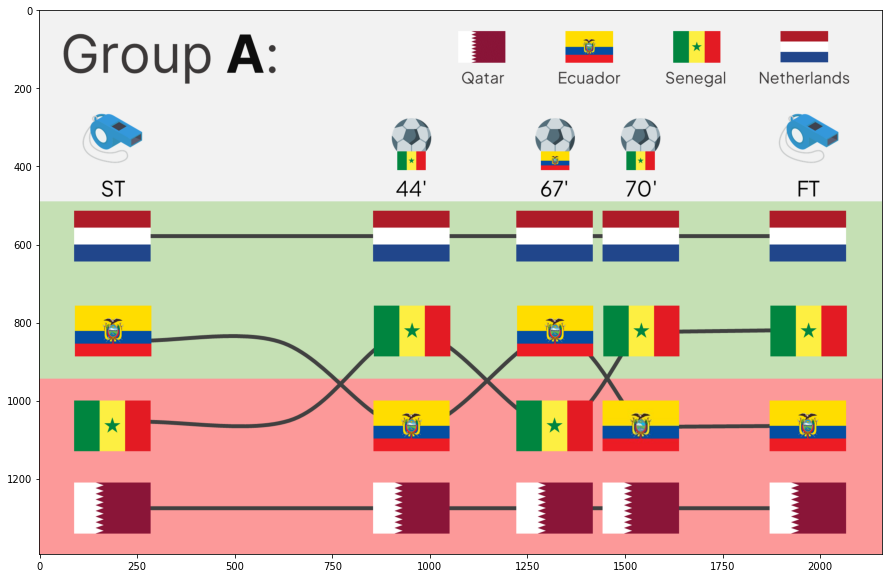


Group B:


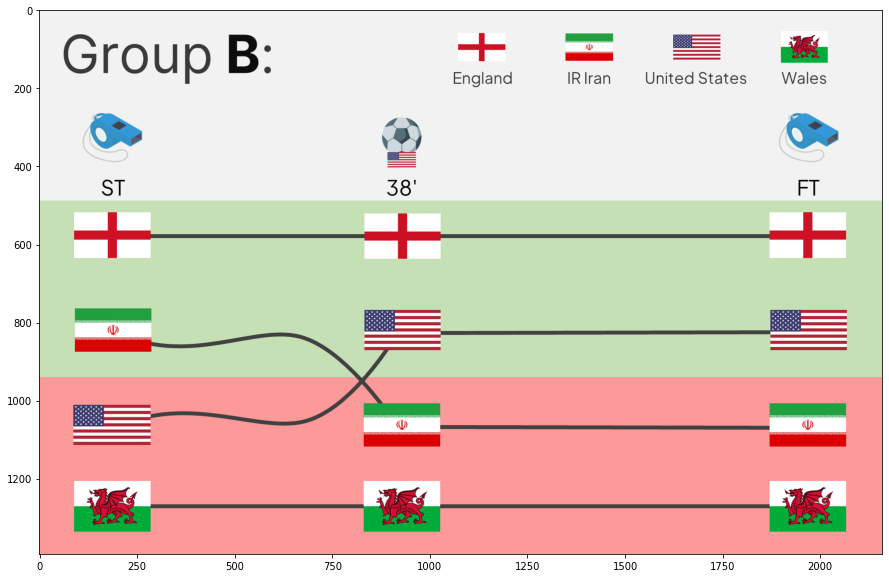


Group C:


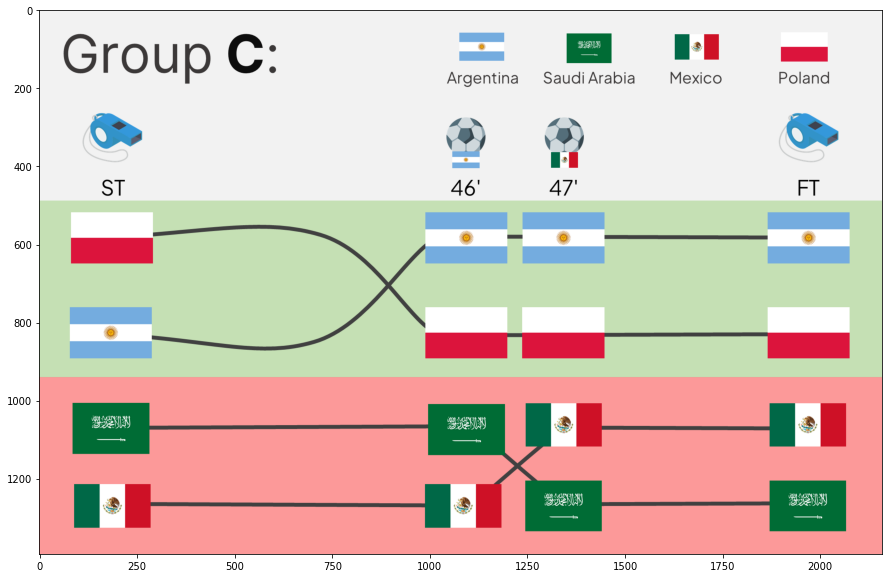


Group D:



Group E:


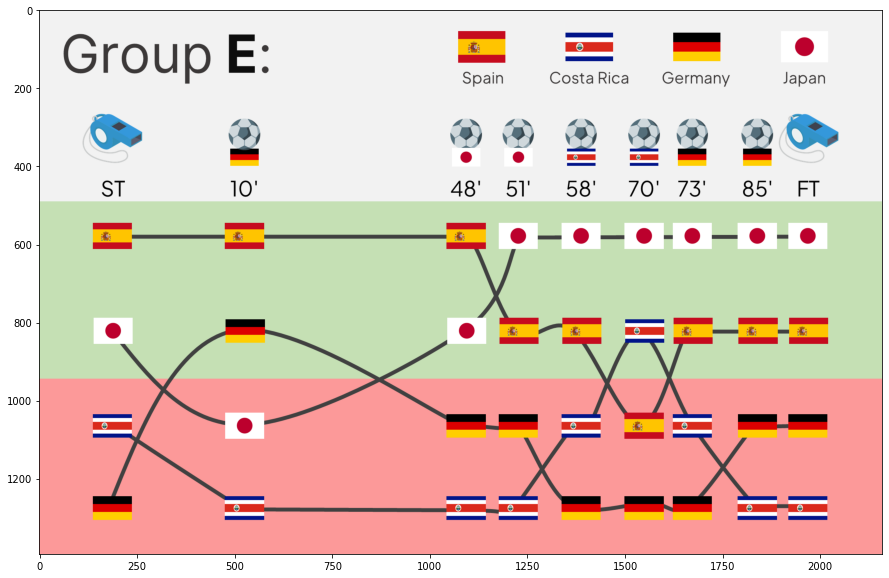


Group F:


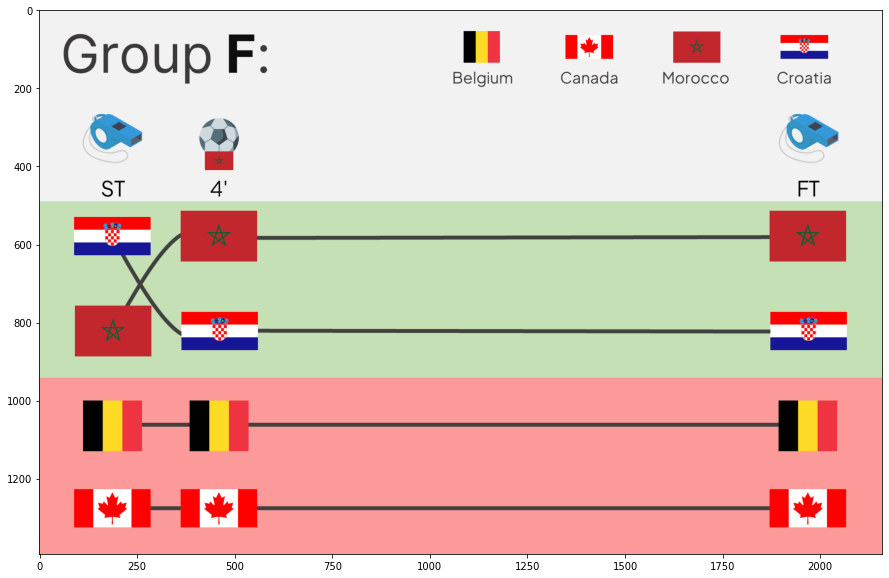


Group G:


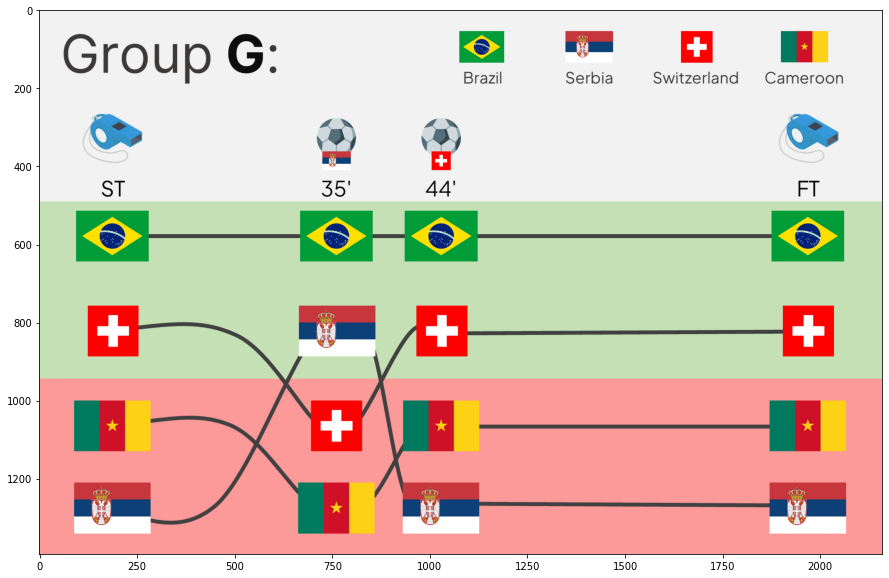


Group H:


In [16]:
for group in groups_map:
    print(f'Group {group}:')
    changes_df = pd.DataFrame([[time]+teams for time, teams in groups_map[group].ranking_changes], columns=['time', '1st', '2nd', '3rd', '4th'])
    display(HTML(changes_df.to_html()))
    img = mpimg.imread(f'final results/group {group}.png')
    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.show()
    print()

From these results, we can agree that the most exciting group was the group E, with 7 ranking changes during the game, and the most boring was was the group F, with only 1 change during the game that happened at the 4th minute.